In [ ]:
# coding=utf-8
# Copyright 2023 Frank Latos AC8P
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Basic Yagi Design

# Uniform Elements
![Graph](img/yagi%201.png)

The easiest Yagi design is one where ```GW``` cards are used to define simple, uniform-diameter elements:

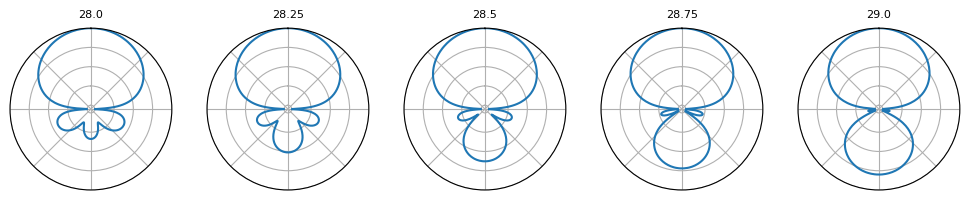

In [1]:
from necutil import nec5_sim_stdio3, plot_complex_z, plot_azimuth2, plot_elevation, plot_vswr, in2m, plot_azimuth_thumb
from necutil import gen_tapered_el2

import numpy as np

# A simple 3-el Yagi with uniform 0.5" elements
els = in2m( np.array([220,201.6,192.2]) )               # Element lengths (inches, convert to meters)
spc = in2m( np.array([36,54]) )                         # Element spacings (inches, convert to meters)
rad = in2m(0.5) / 2                                     # Element radius (m)

yagi = '\n'.join(
    ['CE 3-el Yagi in free space',               
     
# Elements: <tag> <#segments> <x,y,z start> <x,y,z end> <radius>
     f'GW 1 20 -{spc[0]} -{els[0]/2} 0 -{spc[0]} {els[0]/2} 0 {rad}',       # R
     f'GW 2 20 0 -{els[1]/2} 0 0 {els[1]/2} 0 {rad}',                       # DE
     f'GW 3 20 {spc[1]} -{els[2]/2} 0 {spc[1]} {els[2]/2} 0 {rad}',         # D
     
     'GE 0 0',                                          # End of geometry; no ground plane specified

# Specify excitation:
#  <0=voltage src 4=current src> <tag> <segment#> <1='near' end, 2='far' end> <real, imag magnitudes>
# Our driven el has tag=2 and 20 segments (numbered 1-20) so midpoint is at far end of segment 10
     'EX 4 2 10 2 1.0 0.0',                             # Excitation: current source (1A), tag=2, segment=10, far end=2

     'FR 0 11 0 0 28.0 0.1',                            # Frequencies for XQ card: 28.0 - 29.0 MHz
     'XQ 0',                                            # Simulate feedpoint impedance
     'FR 0 5 0 0 28.0 0.25',                            # Frequencies for RP card: 28.0,28.25,28.5,28.75,29.0 MHz
     'RP 0 1 360 0000 90 0 0 1',                        # Only for theta=90 (horizon)
     'EN\n'                                             # End
    ])

result = nec5_sim_stdio3([yagi])

# Plot rad patterns for each freq in a grid
freqs,arrs = zip(*result[0][1][0])
plot_azimuth_thumb(arrs, titles=freqs, nolabels=True)


# Multi-Section Elements
![Graph](img/yagi%202.png)

Most practical designs will utilize tapered aluminum tubing.  The ```gen_tapered_el2``` function will generate the multiple ```GW``` cards needed to describe the element:

In [2]:
# Section lengths and diameters (68" tip sections of 0.5" tubing, etc.)
seclist = [(68,0.5),(18,0.625),(48,0.75),(18,0.625),(68,0.5)]

# Args: section list, x and z coords, tag, number of segments for entire element
elem_str, feed_sec = gen_tapered_el2(seclist, 0, 0, 1, 20, inches=True)

# Returns a string containing multiple GW cards, and the segment number to use as the feedpoint if a driven element.
print(feed_sec)
print(elem_str)

# The number of NEC segments for the element is specified. They're proportionately distributed among the tubing sections.
# The number per section is rounded up to the next integer, so you may end up with slightly more than specified.


10
GW 1 6 0 -2.7939984912408145 0 0 -1.0667994239283107 0 0.006349996571001852
GW 1 2 0 -1.0667994239283107 0 0 -0.6095996708161775 0 0.007937495713752315
GW 1 4 0 -0.6095996708161775 0 0 0.6095996708161779 0 0.009524994856502777
GW 1 2 0 0.6095996708161779 0 0 1.0667994239283112 0 0.007937495713752315
GW 1 6 0 1.0667994239283112 0 0 2.793998491240815 0 0.006349996571001852



Here's the same design as before but with telescoping tubing:

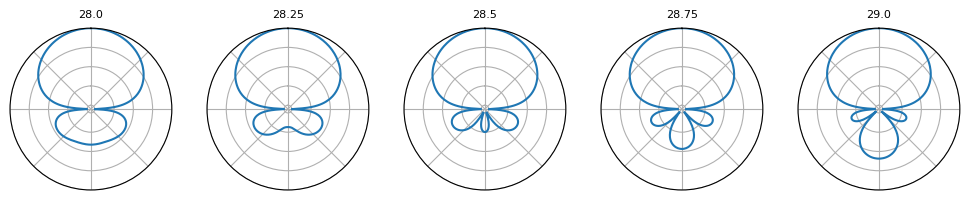

In [20]:
# A simple 3-el Yagi using 0.5, 0.625, 0.75" tubing sections
els = [ 
        [(68,0.5),(18,0.625),(48,0.75),(18,0.625),(68,0.5)],        # A list of the three elements' tubing sections
        [(58.8,0.5),(18,0.625),(48,0.75),(18,0.625),(58.8,0.5)],
        [(54.1,0.5),(18,0.625),(48,0.75),(18,0.625),(54.1,0.5)]
      ]
x_pos = in2m( np.array([-36,0,54]) )                      # X coords of elements (inches, convert to meters)

yagi = [
    'CE 3-el Yagi in free space',               
     
# Placeholders for the strings generated by gen_tapered_el2()
     '',            
     '',
     '',
     
     'GE 0 0',                                          # End of geometry; no ground plane specified

# Specify excitation:
#  <0=voltage src 4=current src> <tag> <segment#> <1='near' end, 2='far' end> <real, imag magnitudes>
# Our driven el has tag=2 and 20 segments (numbered 1-20) so midpoint is at far end of segment 10
     'EX 4 2 {feedpoint_seg} 2 1.0 0.0',                # Excitation: current source (1A), tag=2, segment=?, far end=2

     'FR 0 11 0 0 28.0 0.1',                            # Frequencies for XQ card: 28.0 - 29.0 MHz
     'XQ 0',                                            # Simulate feedpoint impedance
     'FR 0 5 0 0 28.0 0.25',                            # Frequencies for RP card: 28.0,28.25,28.5,28.75,29.0 MHz
     'RP 0 1 360 0000 90 0 0 1',                        # Only for theta=90 (horizon)
     'EN\n'                                             # End
    ]


elem_str, _ = gen_tapered_el2(els[0], x_pos[0], 0, 1, 20, inches=True)
yagi[1] = elem_str[:-1]
elem_str, feed_seg = gen_tapered_el2(els[1], x_pos[1], 0, 2, 20, inches=True)
yagi[2] = elem_str[:-1]
elem_str, _ = gen_tapered_el2(els[2], x_pos[2], 0, 3, 20, inches=True)
yagi[3] = elem_str[:-1]

# Join into a single string and run the simulation
yagi = '\n'.join(yagi).format(feedpoint_seg=feed_seg)
result = nec5_sim_stdio3([yagi])

# Plot rad patterns for each freq in a grid
freqs,arrs = zip(*result[0][1][0])
plot_azimuth_thumb(arrs, titles=freqs, nolabels=True)
